In [12]:
import uproot
import numpy as np
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt


In [37]:
fastnwbls = uproot.open('data/fastn_wbls.root'+':data')
ibdwbls = uproot.open('data/ibd_wbls.root'+':data')
fastnwbls = fastnwbls.arrays(library='awkward')
ibdwbls = ibdwbls.arrays(library='awkward')

In [38]:
# Time-sort all the data arrays for recurrent/sequential purposes. 
for j, data in enumerate([fastnwbls, ibdwbls]):
#     data['restime'] = data['hittime']
    print('set %i'%(j))
    args = ak.argsort(data['hittime'])
    for key in ['hittime', 'pmtcharge', 'channel']:
        data[key] = data[key][args]

set 0
set 1


In [41]:
# Get rid of the first and last events of each run 
ibdwbls = ibdwbls[ibdwbls['inner_hit_prev']>0]
ibdwbls = ibdwbls[ibdwbls['inner_hit_next']>0]
ibdwbls = ibdwbls[ibdwbls['dt_prev_us']>0]
fastnwbls = fastnwbls[fastnwbls['inner_hit_prev']>0]
fastnwbls = fastnwbls[fastnwbls['inner_hit_next']>0]
fastnwbls = fastnwbls[fastnwbls['dt_prev_us']>0]

In [45]:
ak.to_json(ibdwbls, 'data/ibd_wbls.json')
ak.to_json(fastnwbls, 'data/fastn_wbls.json')


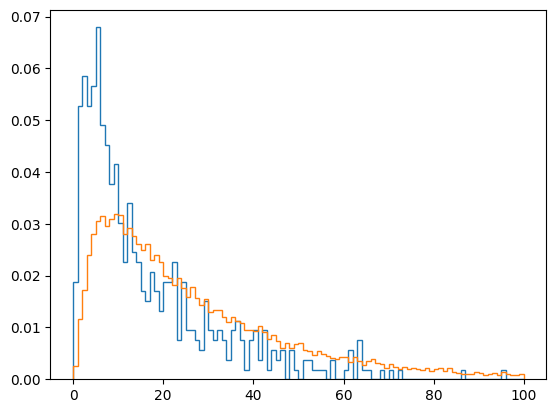

In [44]:
kw = dict(bins=np.linspace(0,100,101),histtype='step', density=True)
plt.hist(fastnwbls.dt_prev_us, **kw)
plt.hist(ibdwbls.dt_prev_us, **kw)
plt.show()

Separate out prompt/delayed IBD and delta-ray/neutron capture fast-neutrons

In [53]:
# Get rid of the first and last events of each run 
ibd = ibd[ibd['inner_hit_prev']>0]
ibd = ibd[ibd['inner_hit_next']>0]
ibd = ibd[ibd['dt_prev_us']>0]
fastn = fastn[fastn['inner_hit_prev']>0]
fastn = fastn[fastn['inner_hit_next']>0]
fastn = fastn[fastn['dt_prev_us']>0]

In [70]:
# Time-sort all the data arrays for recurrent/sequential purposes. 
for j, data in enumerate([fastn, ibd]):
#     data['restime'] = data['hittime']
    print('set %i'%(j))
    args = ak.argsort(data['hittime'])
    for key in ['hittime', 'pmtcharge', 'channel']:
        data[key] = data[key][args]

set 0
set 1


Separate out prompt/delayed IBD and delta-ray/neutron capture fast-neutrons

In [73]:
# Get rid of the first and last events of each run 
ibd = ibd[ibd['inner_hit_prev']>0]
ibd = ibd[ibd['inner_hit_next']>0]
ibd = ibd[ibd['dt_prev_us']>0]
ibd = ibd[ibd['dt_next_us']>0]
fastn = fastn[fastn['inner_hit_prev']>0]
fastn = fastn[fastn['inner_hit_next']>0]
fastn = fastn[fastn['dt_prev_us']>0]
fastn = fastn[fastn['dt_next_us']>0]

Make sure all times that are larger than ~600 us are set to some constant, e.g. 500 us. 
<br>
This is because the rates are arbitrary in the case of us using these samples -- these are just injected rates. 

In [75]:
dims = ak.fields(data)
prev_vars = [i for i in dims if 'prev' in i.lower()]
post_vars = [i for i in dims if 'next' in i.lower()]
proxvars = np.append(prev_vars, post_vars)

In [76]:
prev_vars_replace = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
                     1e4, 1e4, 1e4, 1e4, 600, 
                     0, 0, 0, 0, 0, 0]
post_vars_replace = [0, 0, 0, 0, 0, 0, 0, 0, 0, 
                     1e4, 1e4, 1e4, 1e4, 600]
                     

In [77]:
def calcr(data):
    data['r'] = np.sqrt(data['x']**2+data['y']**2)
    return data

In [78]:
#do we need to also remove the distance information? 
for data in [fastn, ibd]:
    data = calcr(data)
    for t, varbls, replace in zip(['dt_prev_us', 'dt_next_us'], [prev_vars, post_vars], 
                        [prev_vars_replace, post_vars_replace]):
        prox_mask = data[t]<600
        for k, key in enumerate(varbls): 
            data[key] = ak.where(prox_mask, data[key], replace[k])

In [79]:
dimensions = [
    'n9', 'n9_prev', 'n9_next',
    'x', 'y', 'z',  'r',
    'id_plus_dr_hit', 'inner_hit_prev', 'inner_hit_next',
    'good_dir', 'good_dir_prev', 'good_dir_next',
    'good_pos','good_pos_prev', 'good_pos_next',
    'distpmt', 
    'closestPMT', 'closestPMT_prev', 'closestPMT_next', 
    'drPrevr', 'dzPrevz', 'drNextr', 'dzNextz',
     'dt_prev_us', 'dt_next_us',
    'azimuth_ks', 'azimuth_ks_prev','azimuth_ks_next',
    'n100', 'pe', 
    'beta_one', 'beta_two', 'beta_three', 'beta_four', 'beta_five', 'beta_six',
    'beta_one_prev', 'beta_two_prev', 'beta_three_prev', 'beta_four_prev', 'beta_five_prev', 'beta_six_prev',
]
def get_dims(data, dimensions=dimensions):
    df_cut = data[dimensions]
    print('Remaining variables selected for analysis: %i'%(len(dimensions)))
    return df_cut

In [80]:
samples = np.min([len(fastn), len(ibd)])

In [81]:
dat1 = get_dims(fastn, dimensions=dimensions)[:samples]
dat2 = get_dims(ibd, dimensions=dimensions)[:samples]

label = np.zeros(2*samples)
label[samples:]=1

Remaining variables selected for analysis: 43
Remaining variables selected for analysis: 43


In [97]:
from sklearn.decomposition import PCA

In [123]:
pc = PCA(0.98)

In [82]:
data = ak.concatenate([dat1, dat2], axis=0)
data = ak.to_pandas(data)

In [83]:
x = StandardScaler().fit_transform(data) # normalizing the features

In [126]:
pcfit = pc.fit_transform(x)

In [127]:
pc.n_components_

27

In [84]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(x, label, test_size=0.25) 

In [129]:
X_train_trans = pc.transform(X_train)
X_test_trans = pc.transform(X_test)


In [130]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(
#     n_estimators=200, max_depth=10
)

#Train the model using the training sets
clf.fit(X_train_trans,y_train)
y_train_pred = clf.predict(X_train_trans)
y_test_pred=clf.predict(X_test_trans)

In [131]:
y_test_prob = clf.predict_proba(X_test_trans)

In [132]:
# Model Accuracy, how often is the classifier correct?
print("Train Accuracy: %.2f%%"%(metrics.accuracy_score(y_train, y_train_pred)*100))
print("Test Accuracy: %.2f%%"%(metrics.accuracy_score(y_test, y_test_pred)*100))

Train Accuracy: 100.00%
Test Accuracy: 81.33%


In [133]:
feature_imp = pd.Series(clf.feature_importances_).sort_values(ascending=False)

In [134]:
indexes = ['pca_'+ str(i) for i in feature_imp.index]

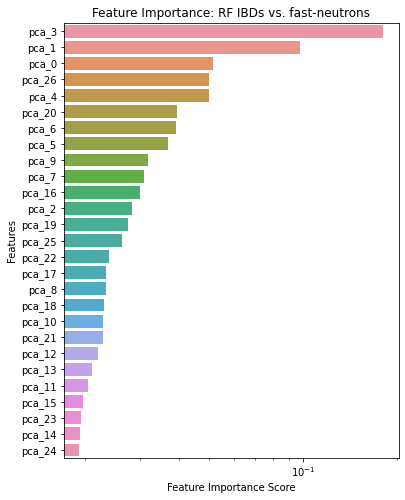

In [135]:
# Creating a bar plot
plt.figure(figsize=(6, 8))
sns.barplot(x=feature_imp, y=indexes)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.xscale('log')
plt.ylabel('Features')
plt.title("Feature Importance: RF IBDs vs. fast-neutrons")
# plt.legend()
plt.show()

In [136]:
scores = y_test_prob[:,1]

In [137]:
fpr, tpr, thresholds = roc_curve(y_test, scores)
auc = roc_auc_score(y_test, scores)

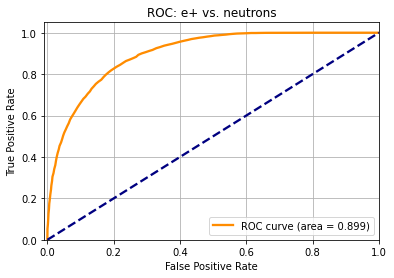

In [138]:
plt.plot(fpr, tpr, 
         label='ROC curve (area = %0.3f)'%(auc), 
         color='darkorange', 
         lw=2.3, 
        )
plt.xlim([-0.01, 1.0])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: e+ vs. neutrons')
plt.plot([0, 1], [0, 1], color='navy', lw=2.3, linestyle='--')
plt.legend()
plt.grid()
# plt.xlim([1e-6, 1.0])
# plt.ylim([1e-2, 1.05])
# plt.xscale('log')
# plt.yscale('log')
plt.show()

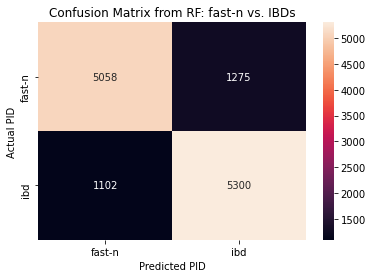

In [139]:
confmat = metrics.confusion_matrix(y_test, y_test_pred)
ax = sns.heatmap(confmat, annot=True, fmt='g', 
#                  norm=LogNorm()
                )

ax.set_title('Confusion Matrix from RF: fast-n vs. IBDs')
ax.set_xlabel('Predicted PID')
ax.set_ylabel('Actual PID')

cmlabels = ['fast-n', 'ibd']
ax.xaxis.set_ticklabels(cmlabels)
ax.yaxis.set_ticklabels(cmlabels)

plt.show()

In [18]:
from sklearn.manifold import TSNE
from sklearn import manifold
from time import time

In [142]:
n_components=2
tsne = TSNE(n_components=n_components, init='pca',
                                 random_state=0)

In [147]:
dimensions = [
    'n9', 'n9_prev', 'n9_next',
    'x', 'y', 'z',  'r',
    'id_plus_dr_hit', 'inner_hit_prev', 'inner_hit_next',
#     'good_dir', 'good_dir_prev', 'good_dir_next',
#     'good_pos','good_pos_prev', 'good_pos_next',
#     'distpmt', 
    'closestPMT', 'closestPMT_prev', 'closestPMT_next', 
    'drPrevr', 'dzPrevz', 'drNextr', 'dzNextz',
     'dt_prev_us', 'dt_next_us',
    'azimuth_ks', 'azimuth_ks_prev','azimuth_ks_next',
    'n100', 'pe', 
    'beta_one', 'beta_two', 'beta_three', 'beta_four', 'beta_five', 'beta_six',
#     'beta_one_prev', 'beta_two_prev', 'beta_three_prev', 'beta_four_prev', 'beta_five_prev', 'beta_six_prev',
]
def get_dims(data, dimensions=dimensions):
    df_cut = data[dimensions]
    print('Remaining variables selected for analysis: %i'%(len(dimensions)))
    return df_cut

In [59]:
samples = np.min([len(fastn), len(ibd)])

In [60]:
dat1 = get_dims(fastn, dimensions=dimensions)[:samples]
dat2 = get_dims(ibd, dimensions=dimensions)[:samples]

label = np.zeros(2*samples)
label[samples:]=1

Remaining variables selected for analysis: 43
Remaining variables selected for analysis: 43


In [61]:
data = ak.concatenate([dat1, dat2], axis=0)
data = ak.to_pandas(data)

In [62]:
x = StandardScaler().fit_transform(data) # normalizing the features

ValueError: Found array with 0 sample(s) (shape=(0, 43)) while a minimum of 1 is required by StandardScaler.

In [158]:
pc = PCA(0.9)

In [161]:
pcfit = pc.fit_transform(x)
print(pc.n_components_)

14


In [25]:
# Split dataset into training set and test set
# X_train, X_test, y_train, y_test = train_test_split(x, label, test_size=0.25) 
X_train, X_test, y_train, y_test = train_test_split(pcfit, label, test_size=0.25, random_state=0) 

NameError: name 'pcfit' is not defined

In [187]:
nsamples = 2000
fitdat = X_train[:nsamples]
t0 = time()
Y = tsne.fit_transform(fitdat)
t1 = time()
dt = t1-t0
print("%.2g sec (%.2f sec/sample)" %(dt, dt/nsamples ))

68 sec (0.03 sec/sample)


In [257]:
group = np.asarray(['ibd' if w==1 else 'fast-n' for w in y_train[:nsamples]])

In [ ]:
plt.figure()
for g in np.unique(group):
    i = np.where(group == g)
    plt.scatter(Y[:, 0][i], Y[:, 1][i], 
#                 c=y_train[:nsamples][i], 
#            cmap=plt.cm.Spectral, 
            label = g
          )
plt.title("t-SNE fastn vs. IBD")
plt.xlabel('tsne0')
plt.ylabel('tsne1')
plt.legend()
plt.show()

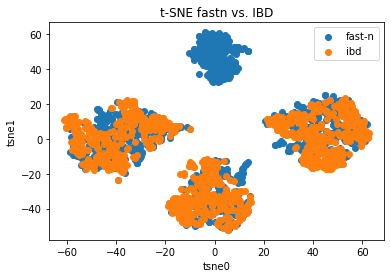

In [262]:
plt.figure()
for g in np.unique(group):
    i = np.where(group == g)
    plt.scatter(Y[:, 0][i], Y[:, 1][i], 
#                 c=y_train[:nsamples][i], 
#            cmap=plt.cm.Spectral, 
            label = g
          )
plt.title("t-SNE fastn vs. IBD")
plt.xlabel('tsne0')
plt.ylabel('tsne1')
plt.legend()
plt.show()

In [208]:
alldat = ak.concatenate([fastn[:samples], ibd[:samples]])

In [132]:
X_og, X_test_og, y_og, y_test_og = train_test_split(data, label, test_size=0.25, random_state=0) 

In [133]:
alln = np.logical_and(Y[:,1]>25, np.abs(Y[:,0])<20)

In [134]:
bottom = np.logical_and(Y[:,1]<0, np.abs(Y[:,0])<20)
left = np.logical_and(Y[:,0]<-10, np.abs(Y[:,1])<20)
right = np.logical_and(Y[:,0]>20, np.abs(Y[:,1])<30)

In [135]:
topclump = X_og[:nsamples][alln]
botclump = X_og[:nsamples][bottom]
rightclump = X_og[:nsamples][right]
leftclump = X_og[:nsamples][left]

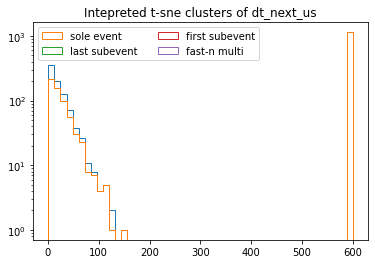

In [138]:
key = 'dt_next_us'
kw = dict(histtype='step', density=False, )
bins = plt.hist(X_og[:nsamples][key],bins=50, **kw)
plt.hist(botclump[key], bins=bins[1], **kw, label='sole event')
plt.hist(rightclump[key], bins=bins[1], **kw, label='last subevent')
plt.hist(leftclump[key], bins=bins[1], **kw, label='first subevent')
plt.hist(topclump[key], bins=bins[1], **kw, label='fast-n multi')
plt.yscale('log')
plt.legend(loc='upper left', ncol=2)
plt.title('Intepreted t-sne clusters of %s'%(key))
plt.show()

In [86]:
X_og, X_test_og, y_og, y_test_og = train_test_split(data, label, test_size=0.25, random_state=0) 

In [87]:
se = manifold.SpectralEmbedding(n_components=2)

In [88]:
nsamples = 2000
fitdat = X_og[:nsamples]
t0 = time()
Y = se.fit_transform(fitdat)
t1 = time()
dt = t1-t0
print("%.2g sec (%.2f sec/sample)" %(dt, dt/nsamples ))

0.75 sec (0.00 sec/sample)


In [89]:
group = np.asarray(['ibd' if w==1 else 'fast-n' for w in y_og[:nsamples]])

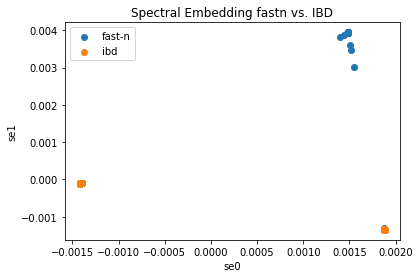

In [90]:
plt.figure()
for g in np.unique(group):
    i = np.where(group == g)
    plt.scatter(Y[:, 0][i], Y[:, 1][i], 
#                 c=y_train[:nsamples][i], 
#            cmap=plt.cm.Spectral, 
            label = g
          )
plt.title("Spectral Embedding fastn vs. IBD")
plt.xlabel('se0')
plt.ylabel('se1')
plt.legend()
plt.show()

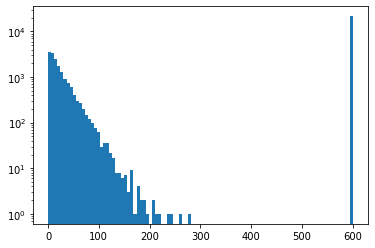

In [92]:
plt.hist(X_og.dt_next_us, bins=100,)
plt.yscale('log')
plt.show()

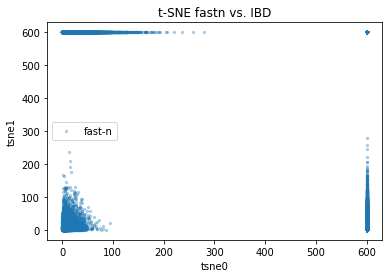

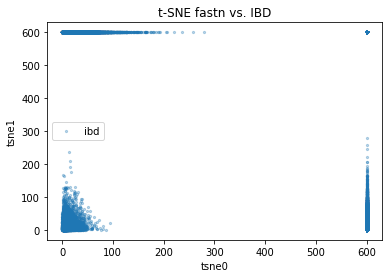

In [98]:
for g in np.unique(group):
    i = np.where(group == g)
    plt.scatter(X_og.dt_prev_us, X_og.dt_next_us, 
            label = g, s=5, alpha=0.3
          )
    plt.title("t-SNE fastn vs. IBD")
    plt.xlabel('tsne0')
    plt.ylabel('tsne1')
    plt.legend()
    plt.show()

## LDA

In [100]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [101]:
x = StandardScaler().fit_transform(data) # normalizing the features

In [102]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(x, label, test_size=0.25) 

In [103]:
lda = LDA(solver="svd", store_covariance=True)
# y_pred = lda.fit(X_train, y_train).predict(X_train)
ldacomp = lda.fit_transform(X_train, y_train)
y_pred = lda.fit(X_train, y_train).predict(X_train)

In [123]:
lda.score(X_test, y_test)

0.7670606776989756

In [117]:
qda = QDA(store_covariance=True)
# y_pred = qda.fit(X, y).predict(X)
qda.fit(X_train, y_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

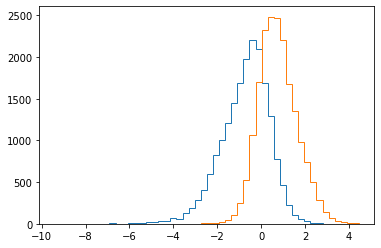

In [115]:
kw = dict(histtype='step', density=False, )
bins = plt.hist(ldacomp[y_train==0], bins=50, **kw)
plt.hist(ldacomp[y_train==1], bins=bins[1], **kw)
plt.show()

In [ ]:
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
y_pred = lda.fit(X, y).predict(X)
splot = plot_data(lda, X, y, y_pred, fig_index=2 * i + 1)
plot_lda_cov(lda, splot)
plt.axis('tight')

# Quadratic Discriminant Analysis
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
y_pred = qda.fit(X, y).predict(X)
splot = plot_data(qda, X, y, y_pred, fig_index=2 * i + 2)
plot_qda_cov(qda, splot)

## Data Prep

Add in residual time and pmt info (can cut for promptness in mask if wanted. Now not doing.) 